## **_Enterprise Data Science and Analytics - Enterprise Data Science Bootcamp_**

### **HR Attrition Project - EDSB25_26**

- Ana Rita Martins 20240821
- Joana Coelho 20240801
- Pedro Fernandes 20240823
- Ricardo Silva 20240824

Data Science and Analytics are reshaping how organizations solve problems across diverse industries. Through systematic data analysis and predictive modeling, evidence-based solutions can be developed, enabling more reliable decision-making and greater efficiency.

In Human Resources, predictive analytics supports critical functions such as employee retention, workforce planning, and automated CV screening.

This project focuses on developing predictive models to assess the likelihood of employee resignation. By analyzing factors ranging from demographics to job satisfaction, the models aim to provide interpretable insights that highlight key drivers of attrition. These insights will help HR leaders take proactive steps to reduce turnover and retain talent.

## 1. Importing Packages

In [2]:
import pandas as pd
from summarytools import dfSummary
import matplotlib.pyplot as plt
import seaborn as sns
#from pandas.io.formats.style import Styler

## 2. Importing Data and Initial Exploration

In [3]:
data = pd.read_csv('../data/raw/HR_Attrition_Dataset.csv')
print(data.head())

   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [5]:
pd.set_option('display.max_columns', None) 
data.describe() 


,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [6]:
data.describe(include='object')

,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
count,1470,1470,1470,1470,1470,1470,1470,1470,1470
unique,2,3,3,6,2,9,3,1,2
top,No,Travel_Rarely,Research & Development,Life Sciences,Male,Sales Executive,Married,Y,No
freq,1233,1043,961,606,882,326,673,1470,1054


From this initial inspection what immediately stands out is that we have 3 constant features: "EmployeeCount", "StandardHours", and "Over18". We can remove those straight away. Additionally, the employee number (ID) feature, does not seem to contain any relevant info, and  we'll drop it too.

In [7]:
data.drop(columns=['EmployeeCount','Over18','StandardHours','EmployeeNumber'],inplace=True)

In [8]:
cat_cols = data.select_dtypes(include=["object"]).columns

for col in cat_cols: 
    print(f"Value counts for column '{col}':")
    print(data[col].value_counts())
    print("\n") 

Value counts for column 'Attrition':
Attrition
No     1233
Yes     237
Name: count, dtype: int64


Value counts for column 'BusinessTravel':
BusinessTravel
Travel_Rarely        1043
Travel_Frequently     277
Non-Travel            150
Name: count, dtype: int64


Value counts for column 'Department':
Department
Research & Development    961
Sales                     446
Human Resources            63
Name: count, dtype: int64


Value counts for column 'EducationField':
EducationField
Life Sciences       606
Medical             464
Marketing           159
Technical Degree    132
Other                82
Human Resources      27
Name: count, dtype: int64


Value counts for column 'Gender':
Gender
Male      882
Female    588
Name: count, dtype: int64


Value counts for column 'JobRole':
JobRole
Sales Executive              326
Research Scientist           292
Laboratory Technician        259
Manufacturing Director       145
Healthcare Representative    131
Manager                      102
Sale

In [9]:
dfSummary(data)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Age[int64],Mean (sd) : 36.9 (9.1)min < med < max:18.0 < 36.0 < 60.0IQR (CV) : 13.0 (4.0),43 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjcsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvTLEjVAAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAmpJREFUeJzt3UGOokAYhuGqgZ4wmmCMie68wCS9cOkh5rBzhFl4Am/gzsQYjXQTEOnQ68mMAjZ8P++zx2bxNgGKqvJlWTqg7751fQLAPUJnlPf+h3Pue4OfyMqyfG/xlNBAaDXS2Wz2K47jad3fOJ/PR+/9b2LtB5OhVlfSKtL1ev0+mUzSRw8+nU7RZrOZHg6H6opMqD1gNdRPVaTz+fytzrFFUcTOudh7X+dwbhtaZjrUupIkecnz/HW5XAZBEDx8Rea2oX2E+hdZloVRFI1Wq1W6WCyOjxzLbcNzEOo/jMfjurcO1RsHtIj3qJBAqJBAqJBAqJAQGh0GjW+328sTTgkdCS0Og+Z5HhVF8TNN0z/OuVov/JsoiqL6J2GwYAihNhkG3e120+12O7per4H7YgwWDC/U2sOgx+Oxs/eYDBYMNFRVDBa0i6d+SCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSGAqSs80nMFqdhYrofZI0xmslmexEmqPNJnBan0WK6HamsFqdhYrD1OQQKiQQKiQEPZ4UzJW5MPzQ226KVnXK/JhOFfURpuSdbkiHwb4eqrupmRdrsinrDC6NivvUQ1JDK/NSqiGZIbXZiVUg8YG12YlVEh8uUWokPhyi1Ah8eUWoULiyy3G+iHhv1dUds9D70NV3j0Pw7qiSu6eB3vDt6HF3fNgb/iWp35IDN8SKiSGb3k9BQmECgmECgmECgmECgmECgmECgmECgnhvSMHj/7w5XL5PCZJkmi/34++8njVv6163q7h8ff09QH5NMarfzIoawAAAABJRU5ErkJggg=="">",0(0.0%)
2,Attrition[object],1. No2. Yes,"1,233 (83.9%)237 (16.1%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjcsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvTLEjVAAAAAlwSFlzAAAPYQAAD2EBqD+naQAAASpJREFUeJzt2z1qw0AUReGZIEzSSBiBFqNFeLFehHYjglTEwc2EKbyEd3gO5yvcTuHjX+bW1lqRCLWU8lVKuSCnKbNna+0RecAwz/NtHMdr5CHK7zzP71rrPTK4oYe2rutjmqbfqEOU23Ecn9u2Xfd9759wcbH1hx7asiw/UYfoLfSvU6E+og+QXoxNGGMTxtiEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhDE2YYxNGGMTZnhdnuOOVDbU8z/068D9liZxeU559Q76DiHyDAcvwgYv1SmfKNQ7W/irRvkhUz5iJqb8wqd81ExM+VFTPn/pyj91xTE2YYxNGGMTxtiEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhDE2YYxN/2fK50xQ6JSPmIkpPwcvKpQ/Cltq3zMouvQAAAAASUVORK5CYII="">",0(0.0%)
3,BusinessTravel[object],1. Travel_Rarely2. Travel_Frequently3. Non-Travel,"1,043 (71.0%)277 (18.8%)150 (10.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjcsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvTLEjVAAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAYNJREFUeJzt20FqwlAYhdGXIqWdKCK4GBfRxXYR2Y2IGWhxkvJ2oAg3/HrOoNME+tWY8u4wz3ODhI/IVaC1NrTWvltrn0vfCA+7zfN8bYWsdrvdz3q93i59IzxmmqbTMAy/lYJb9dAOh8N1s9n8LX0z3Od8Pn+N47g9Ho/9iVQntv6jh7bf7y9L3wwP6V9/SvGCQIzYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI3sEaN+Pip3SZ5V9fe16ic++0G8iuej3tk0Tad+NLwVYoNQ163SkfBuMOXj1T/Zyv1VUnRdVXEZRMF1VdVlEHXXVd5835B/6hIjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWLjdddVVZdBFF1XVVwG8TwbBGKsq4jxgkCpx6hHIpkpn1kekSmfWR7pKZ9ZHnfxgkCM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGlM+szyiUz6zPO5lg0CMKR8t5R9KvKNKejbZqwAAAABJRU5ErkJggg=="">",0(0.0%)
4,DailyRate[int64],Mean (sd) : 802.5 (403.5)min < med < max:102.0 < 802.0 < 1499.0IQR (CV) : 692.0 (2.0),886 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjcsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvTLEjVAAAAAlwSFlzAAAPYQAAD2EBqD+naQAAApFJREFUeJzt3T+O2kAYh+GZACsDii3ECjousFIKSprcIIdNmy5IcAFuQIOQEBjhLMIYItOlCnj4Mz/7fXrDyHplzzdotfZ8PhvAd19evQDgGnVTUtbapjHmzeEjDufz+fOOS4KDelkj7Xa7P8Iw7BT9jO12u7bW/iRWP5Qy1PxJmkc6Go0+oyja33pxHMfBZDLprFar/IlMqB4oa6gXeaS9Xu9PwcvzrUPVtjwHX98gpQ61aqzjlsfn7Q6hlstb0S1Pvt0Zj8e91Wr1bq3d+vZEJtQSigpseZIkaaRp+m0wGNRqtdrN+/pHP5EJFReHw6EeBEFrOBzu+/3+2ng2gBIq/tFut70cQOtVnSIfiXv25FDLPEU+CvfsNU9Upymyoofmlb1nWZY1jDGhtfbub5L6Iw/OsywLHRb+0tegw00PT6dTI4qidcG9nuQPDYnjqcH/3iQPG6bucdyx2Wx21tpfxph9kVjMC9aepmmQZdnHfr//bYwpOpRU6tQgvuJNUvf1uGOxWHydTqffB4PB+7NjcVn7fD7vzGaz1vF4rJkKahc/NWi+9Hiq6MLX63Xz1bEUWXu+bpfvhOg5KrFAItSqcZycQ5e9uc8I1SOuA2ha4kGOUD3iOoDOSzzIEaqHXAZQU1L8FSokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECrK82/Q4zgO

From the summary above, we verified that the data set does't contain duplicates, and we also gathered information about the data's distribution and main statistics.

What we can note is that, beasides our target, we have a couple of other binary features. Let's encode those.

In [10]:
data['Attrition'] = data['Attrition'].map({'Yes': 1, 'No': 0})
data['Gender'] = data['Gender'].map({'Male': 1, 'Female': 0})
data['OverTime'] = data['OverTime'].map({'Yes': 1, 'No': 0})

data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,0,94,3,2,Sales Executive,4,Single,5993,19479,8,1,11,3,1,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,1,61,2,2,Research Scientist,2,Married,5130,24907,1,0,23,4,4,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,4,1,92,2,1,Laboratory Technician,3,Single,2090,2396,6,1,15,3,2,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,0,56,3,1,Research Scientist,3,Married,2909,23159,1,1,11,3,3,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,1,40,3,1,Laboratory Technician,2,Married,3468,16632,9,0,12,3,4,1,6,3,3,2,2,2,2


Let's now have a look at how the distribution of the target variable.

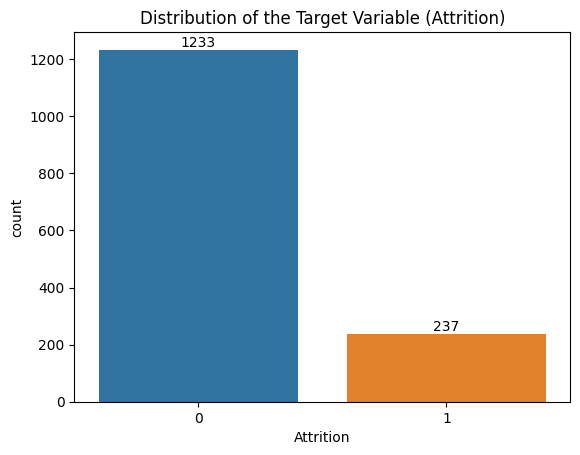

In [11]:
ax = sns.countplot(x=data['Attrition'], hue=data['Attrition'], legend=False)
for container in ax.containers:
    ax.bar_label(container)

plt.title('Distribution of the Target Variable (Attrition)')
plt.show()

We can observe that our target cariable is quite imbalanced. This will require extra attention in later steps, namely when splitting the dataset into train, validation and test sets, as well as during the modelling stage.

In [12]:
data.shape

(1470, 31)

In [13]:
data.head(3)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,0,94,3,2,Sales Executive,4,Single,5993,19479,8,1,11,3,1,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,1,61,2,2,Research Scientist,2,Married,5130,24907,1,0,23,4,4,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,4,1,92,2,1,Laboratory Technician,3,Single,2090,2396,6,1,15,3,2,0,7,3,3,0,0,0,0


# **3. Exploratory Data Analysis**

We'll start by plotting histograms to visually assess the distribution of the numeric features; this will allows us to spot any relevant patterns or trends in the data.

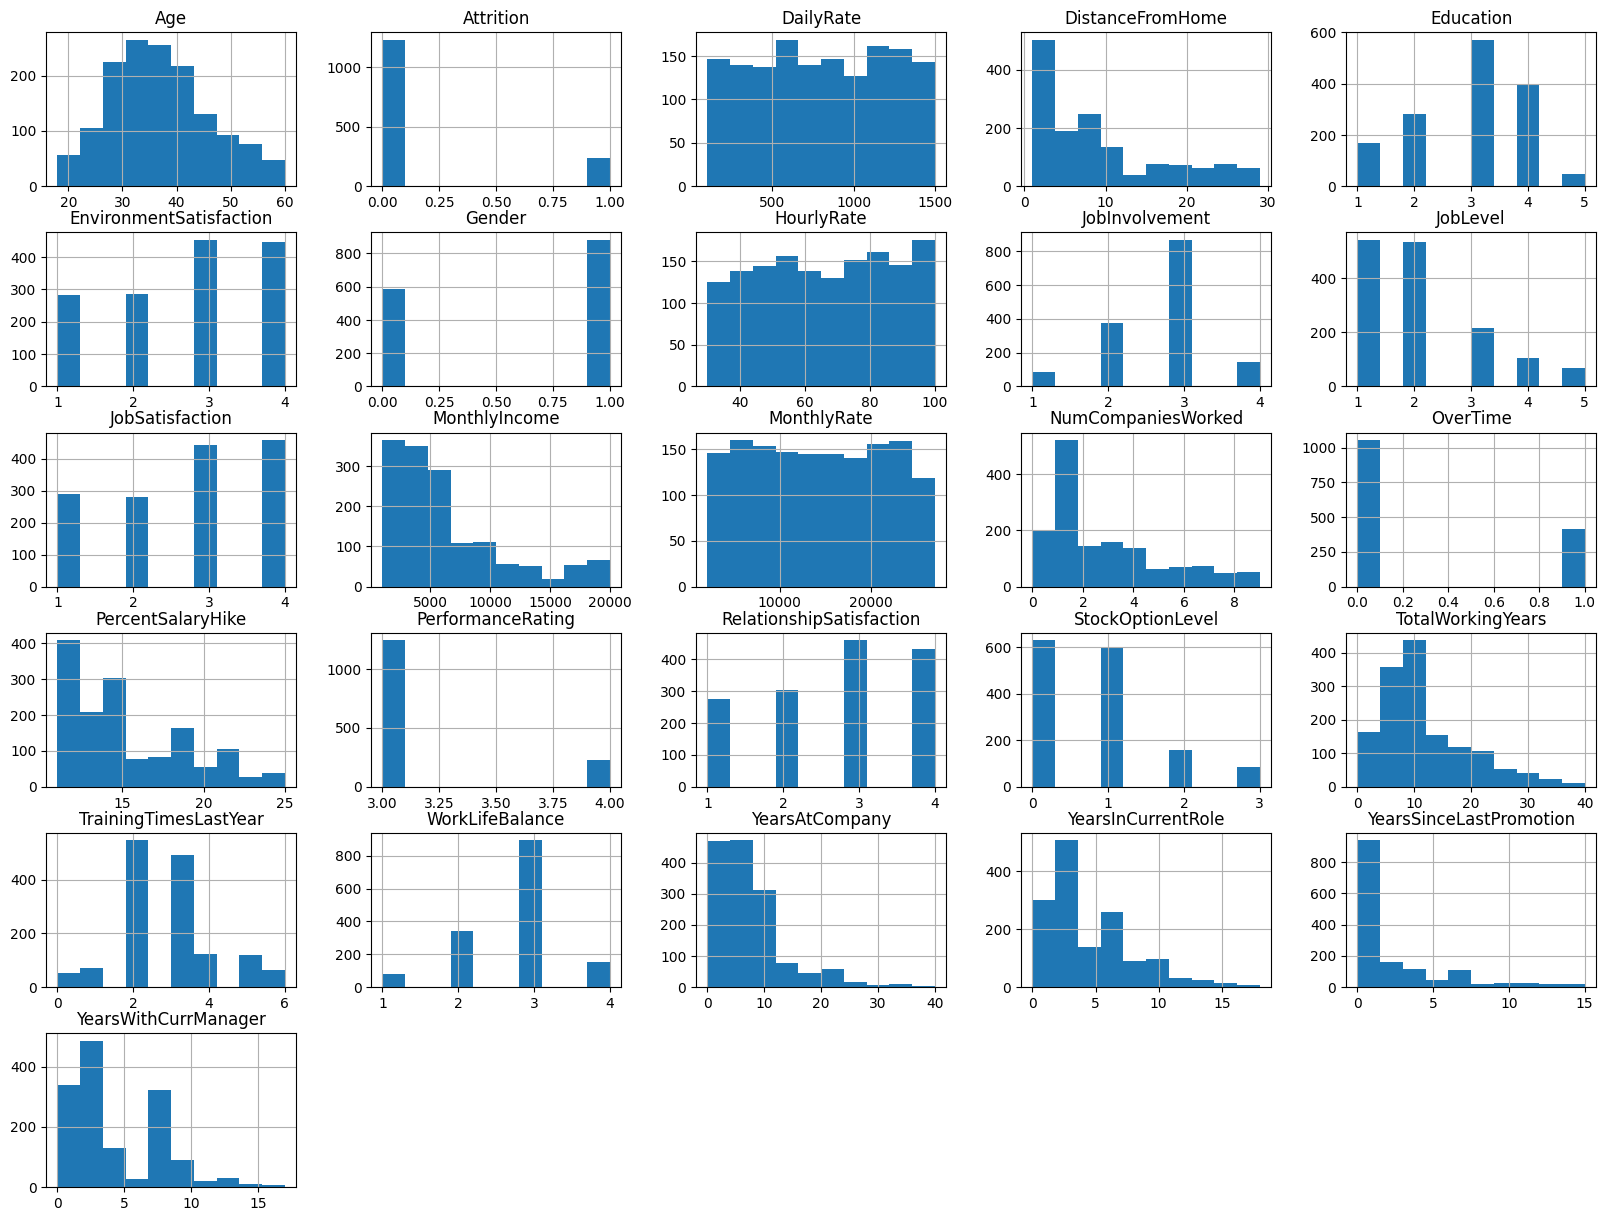

In [14]:
data.hist(figsize=(20, 15))
plt.show()

The histograms reveal some important patterns in the dataset. 
- Once again we can observe that the **target variable** is highly skewed toward staying in the company.
- Concerning demographics, **age** follows an approximately bell-shaped distribution, centered around 30-40; **Gender** is skewed with more males than females.
- Features that are related to **work characteristics** (YearsAtCompany, TotalWorkingYears, YearsInCurrentRole, Overtime) are right-skewed, indicating many relatively new employees and fewer with long careers; working overtime is not common.
- **Income**: Salaries and rates are right-skewed, with few very high earners.
- **Satisfaction-related** variables are discrete and somewhat skewed toward higher ratings, while PerformanceRating shows very little variation (nearly all at level 3), suggesting limited predictive value.

Overall, the data displays strong imbalance and skewness patterns that will require careful consideration during modeling, suggesting it could benefit from stratified splits, and algorithms robust to class imbalance. 

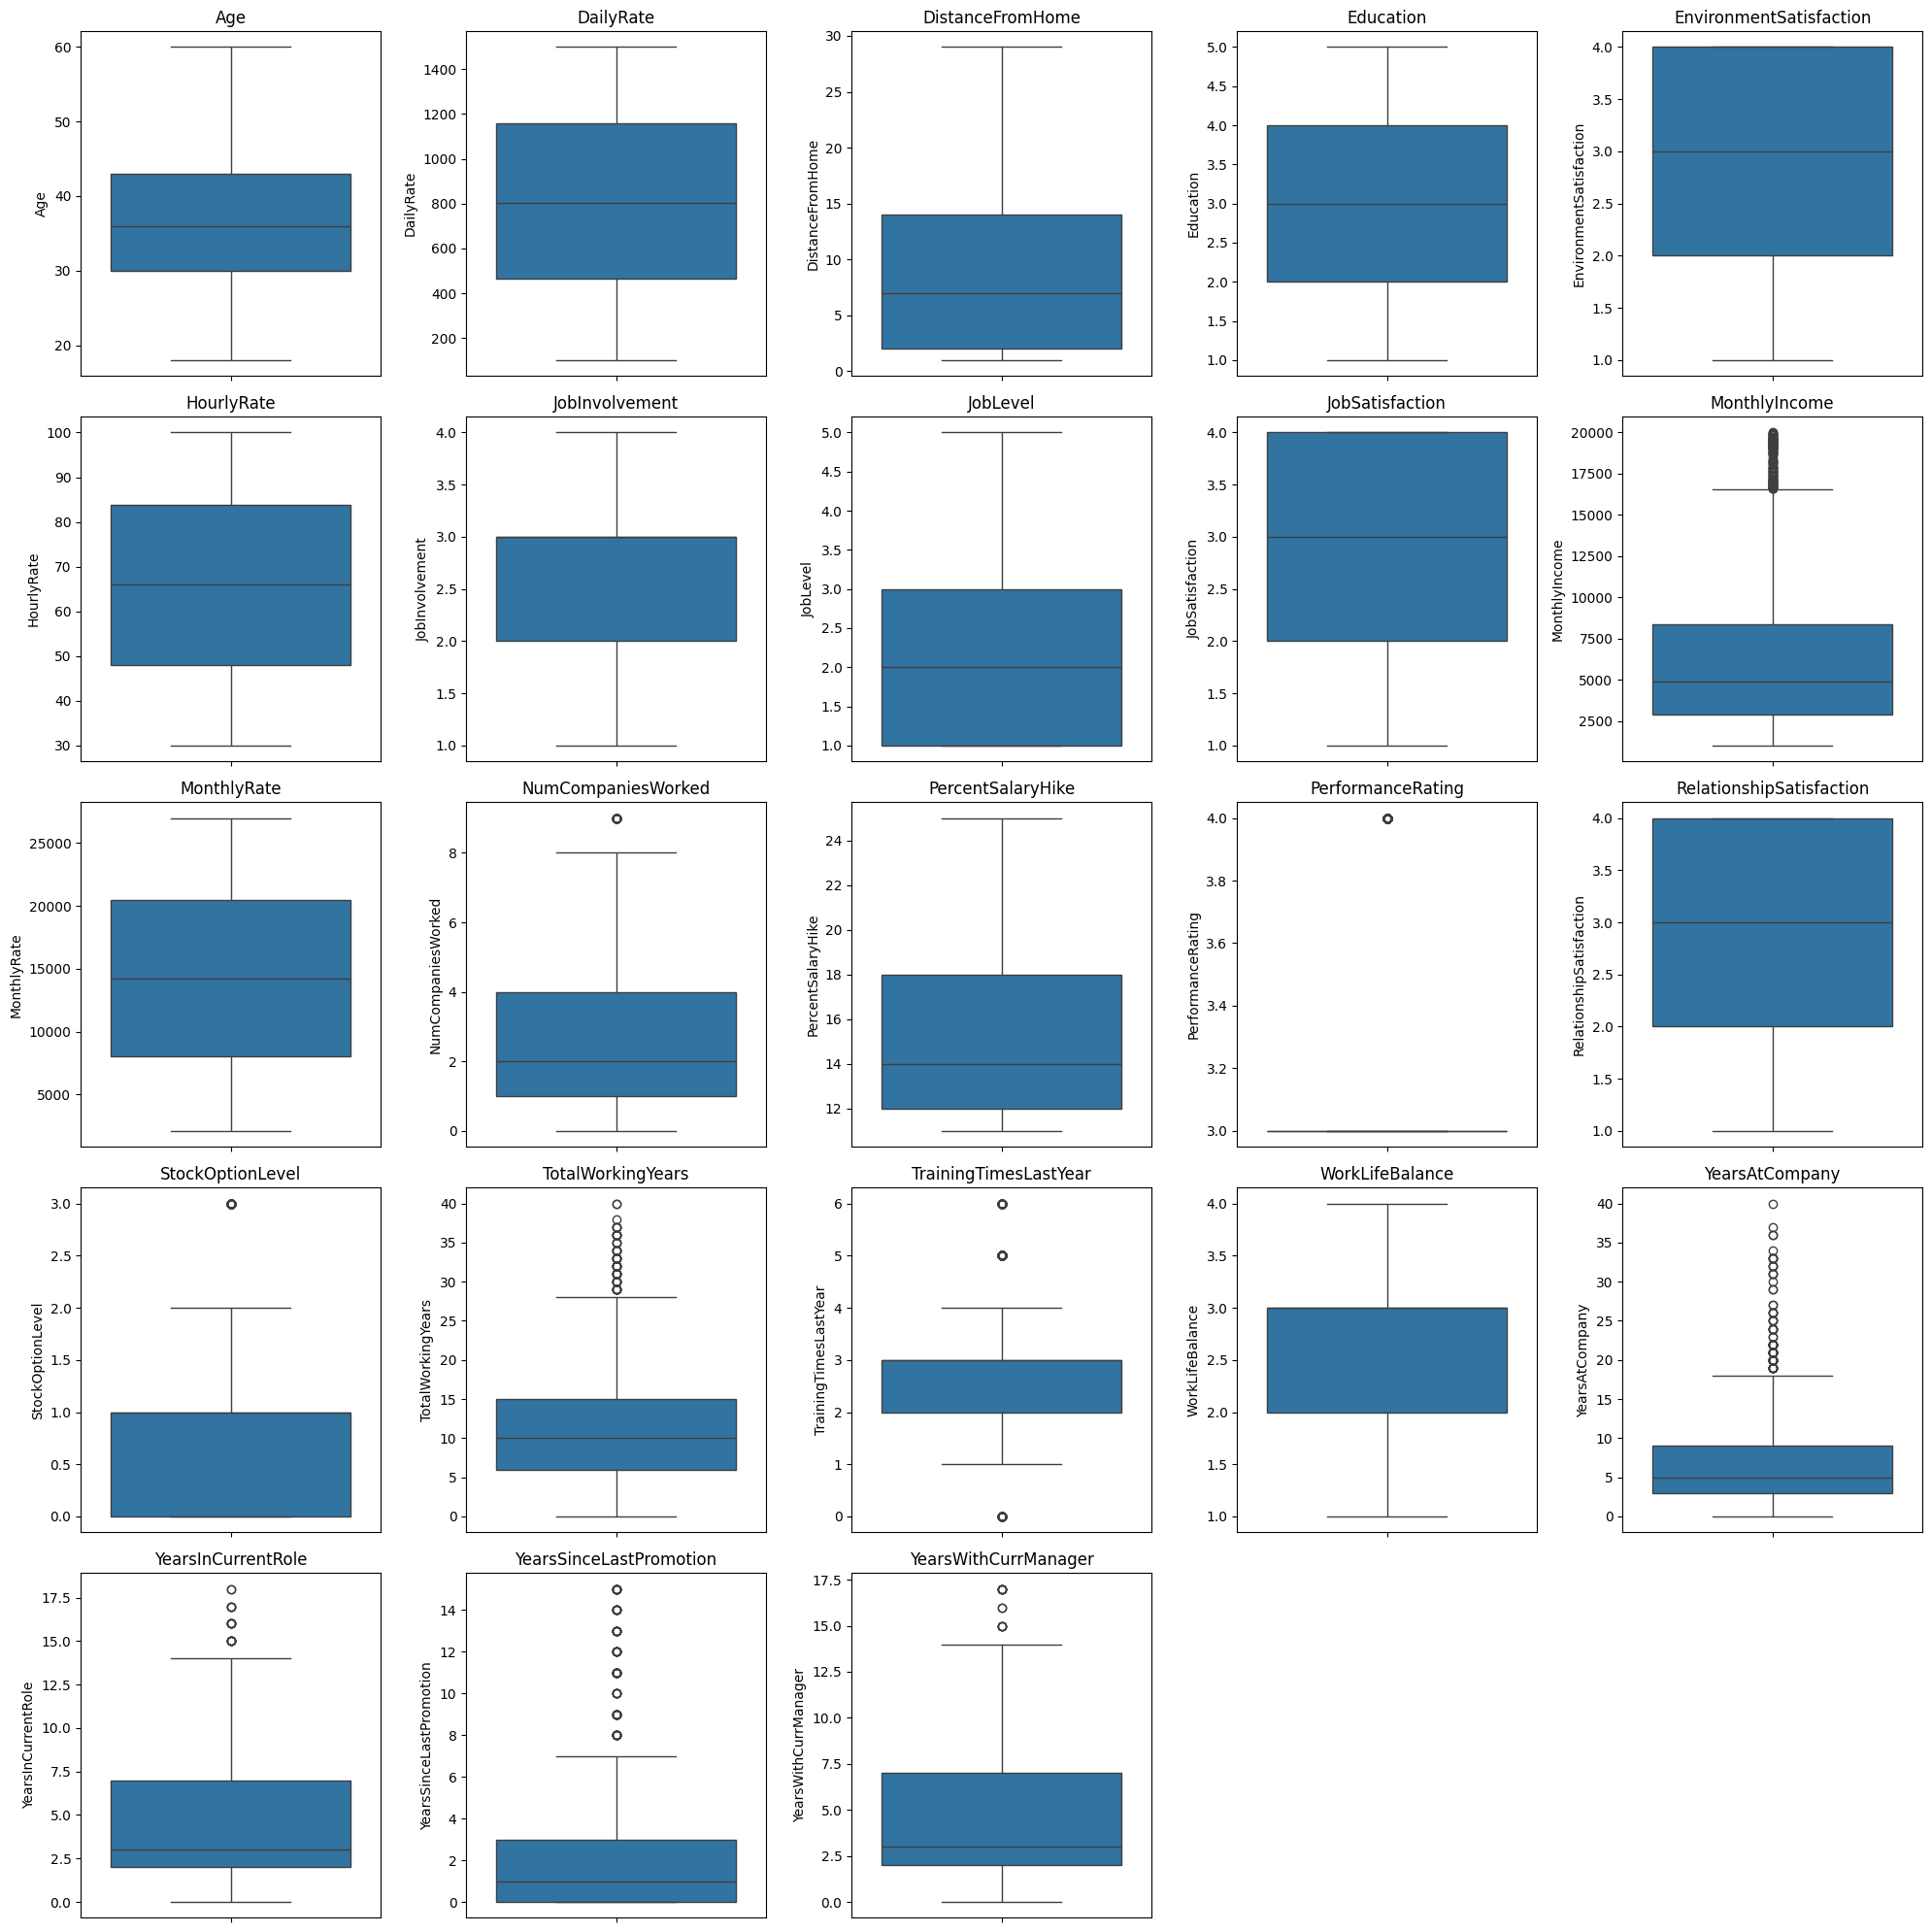

In [15]:
# Selecting  numerical columns (binaries excluded)
binary_cols = ['Attrition', 'Gender', 'OverTime']
num_cols = [col for col in data.select_dtypes(include=['int64', 'float64']).columns if col not in binary_cols]

# Boxplots for each numerical feature
n_cols = 5
n_rows = -(-len(num_cols) // n_cols)  

plt.figure(figsize=(20, 4*n_rows))

for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(y=data[col])
    plt.title(col)

plt.tight_layout()
plt.show()

The boxplots highlight the extent of skewness and make the outliers stand out clearly, which complements the histogram analysis above.
- Outliers are especially relevant in income and emplyment duration related-variables, which may need special handling. We'll decide how to handle them further down.
- For demographic/job characteristics (Age, DistanceFromHome, JobLevel, Education) featured the distributions are fairly compact with few outliers, aligning with the unimodal/bell-like shapes seen in histograms.
- Ordinal satisfaction and variables show limited spread, consistent with their discrete scale, with some level of skew toward higher values. Their limited range may reduce their explanatory power.
- PerformanceRating shows very little variation (nearly all values at level 3) confirming its limited usefulness as a predictive feature.

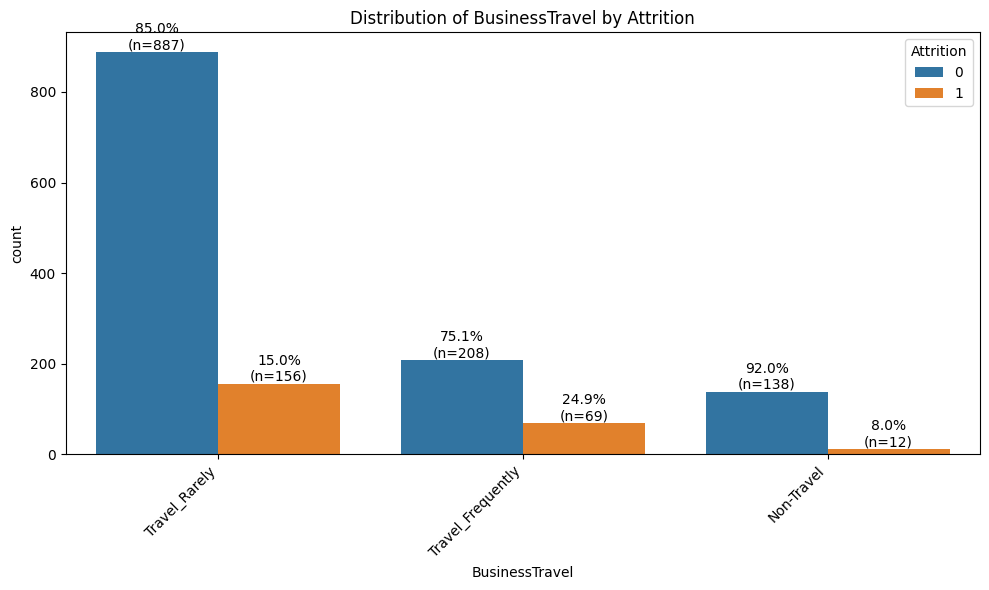

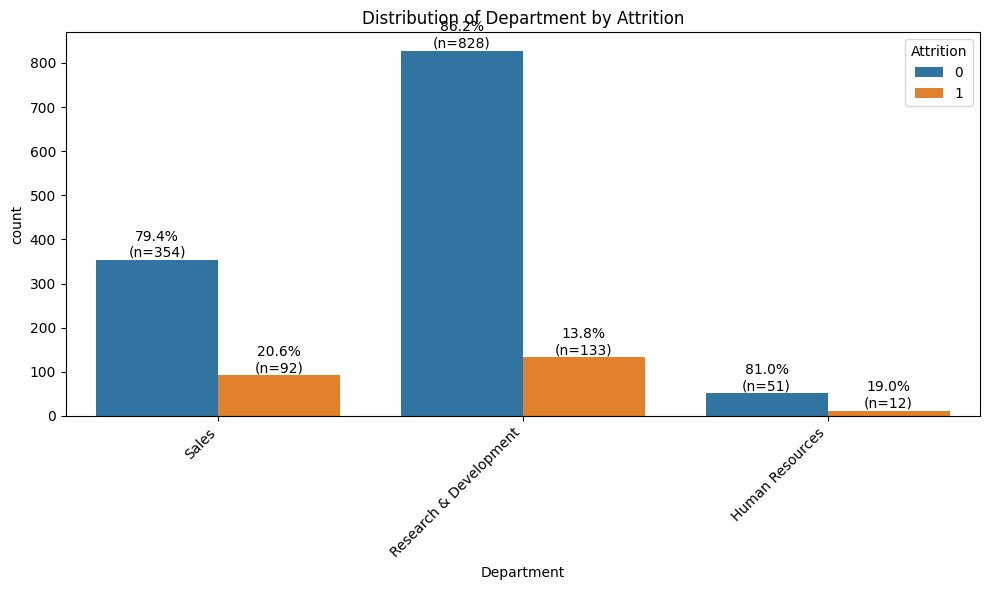

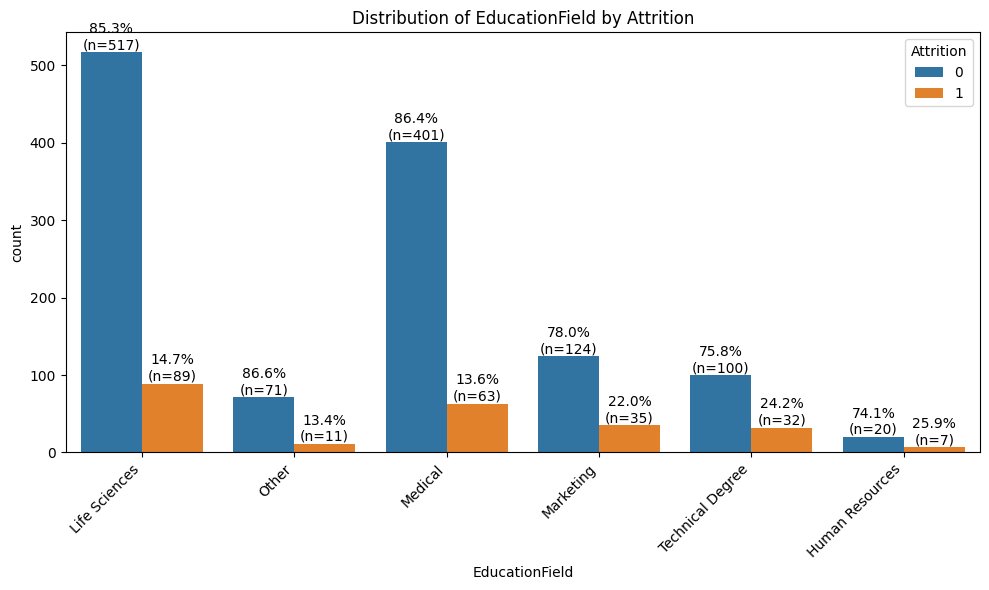

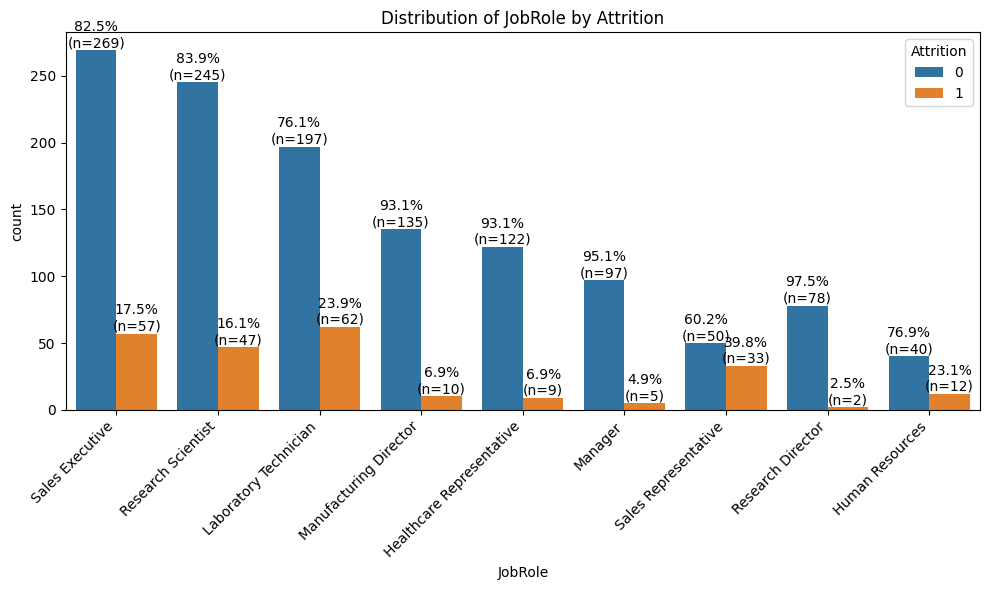

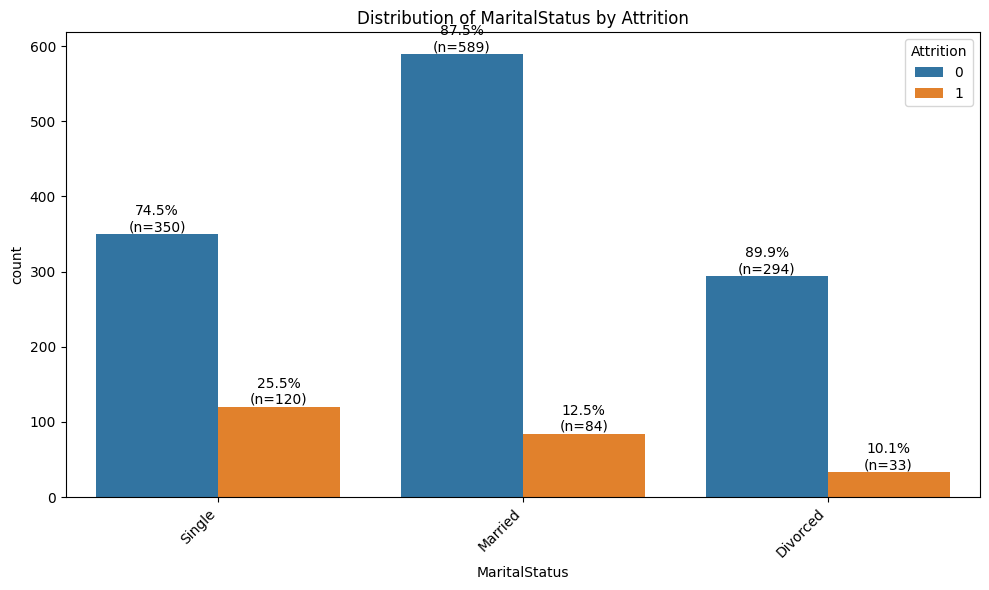

In [32]:
# Selecionar apenas colunas do tipo object (qualitativas)
categorical_cols = data.select_dtypes(include='object').columns.tolist()

# Remover a variável Attrition da lista
if 'Attrition' in categorical_cols:
    categorical_cols.remove('Attrition')

# Criar gráficos para cada variável qualitativa
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    
    # Criar tabela de contingência
    contingency = data.groupby([col, 'Attrition']).size().unstack(fill_value=0)
    
    ax = sns.countplot(x=data[col], hue=data['Attrition'])
    
    for container in ax.containers:
        labels = []
        for i, bar in enumerate(container):
            height = bar.get_height()
            if height > 0:
                # Obter a categoria pela posição da barra
                categories = data[col].unique()
                category = categories[i] if i < len(categories) else categories[0]
                category_total = len(data[data[col] == category])
                percentage = (height / category_total) * 100
                labels.append(f'{percentage:.1f}%\n(n={int(height)})')
            else:
                labels.append('')
        ax.bar_label(container, labels=labels)
    
    plt.title(f'Distribution of {col} by Attrition')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

By analyzing these bar charts, we can identify notable differences in the distribution of Attrition across our categorical variables. Key findings include:

- **Business Travel**: Higher travel frequency might correlate with increased attrition rates, considering the differences between their percentages. This may suggest that frequent business travel may negatively impact employee retention.

- **Education Field and Job Role**: While some correlation between education field and job role is probable (Human Resources, for instance), the Job Role variable reveals a striking pattern: Sales Representatives show nearly 40% attrition rate, significantly higher than other positions.

- **Marital Status**: Single employees demonstrate substantially higher attrition rates compared to their married counterparts. The proportion of single employees leaving the company is more than double that of married employees (relative to their respective group sizes), indicating that marital status may be a relevant predictor of attrition.

These preliminary observations suggest that work-life balance factors (travel, marital status) and specific job roles warrant further investigation in our analysis.

We will also analyze the numerical variables in our dataset. However, before proceeding, it would be interesting to explore a potential relationship between MonthlyIncome and MonthlyRate. While MonthlyIncome represents the actual salary an employee receives each month, MonthlyRate might reflect the hourly rate or the standardized value the company attributes to that employee on a monthly basis. 

To investigate this relationship, we propose creating a new variable - Income_Rate_Ratio - which will capture the ratio between these two metrics and may provide insights into compensation structures and their potential impact on attrition.

In [36]:
data['Income_Rate_Ratio'] = data['MonthlyIncome'] / data['MonthlyRate']

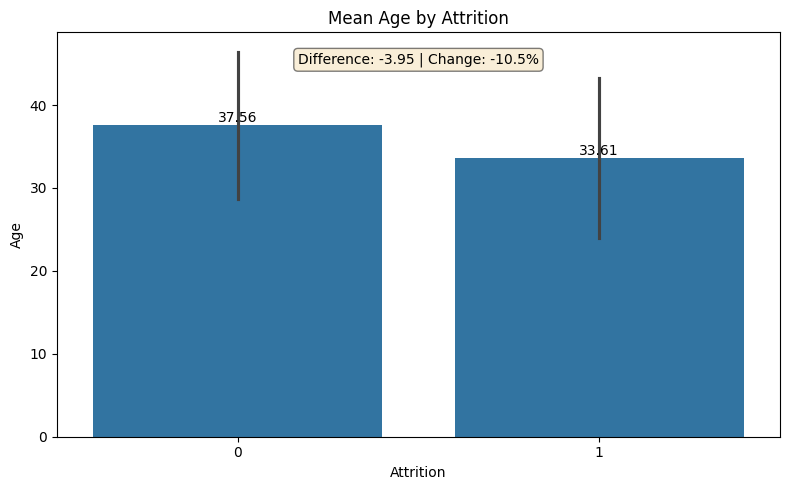

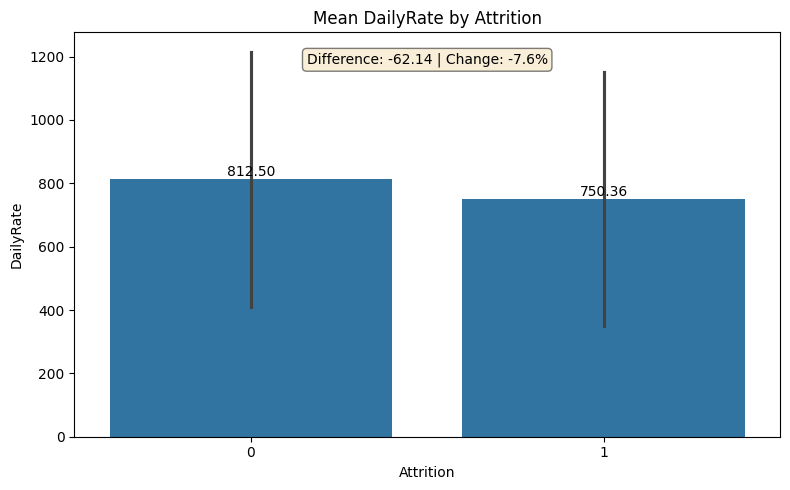

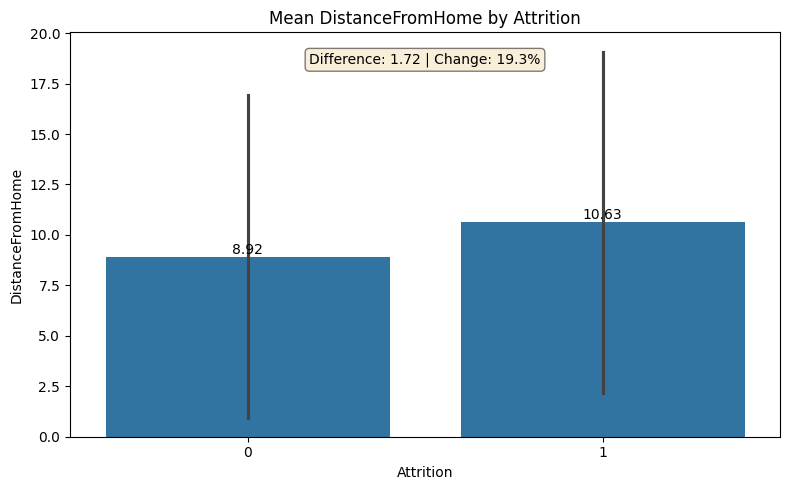

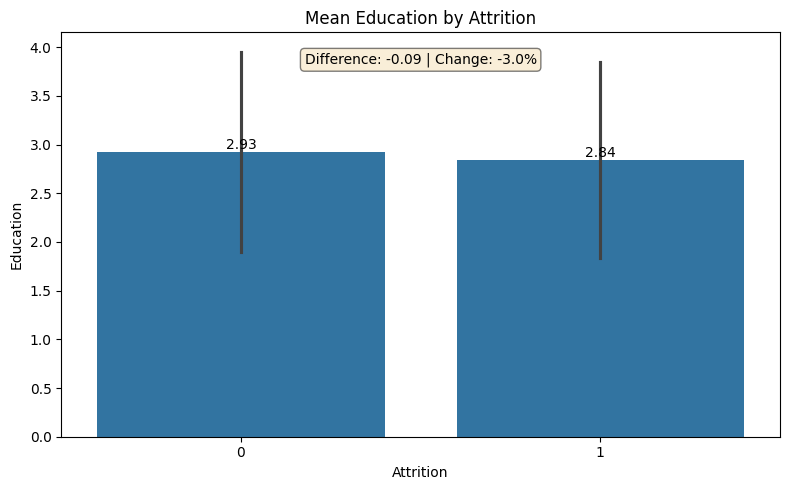

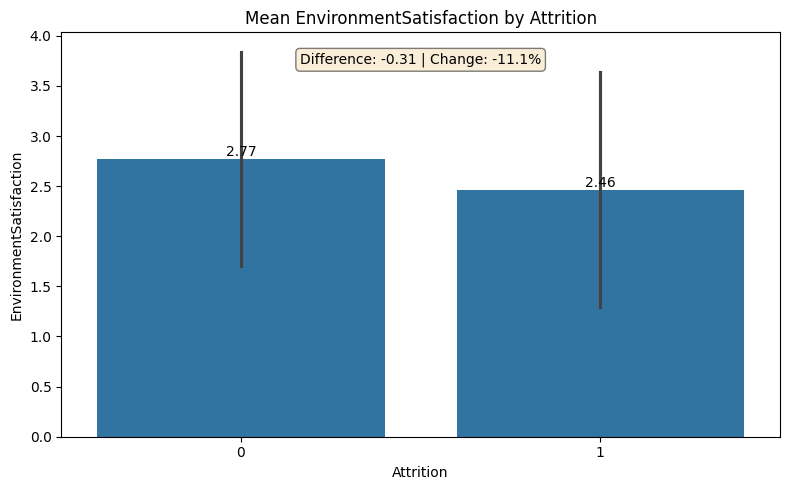

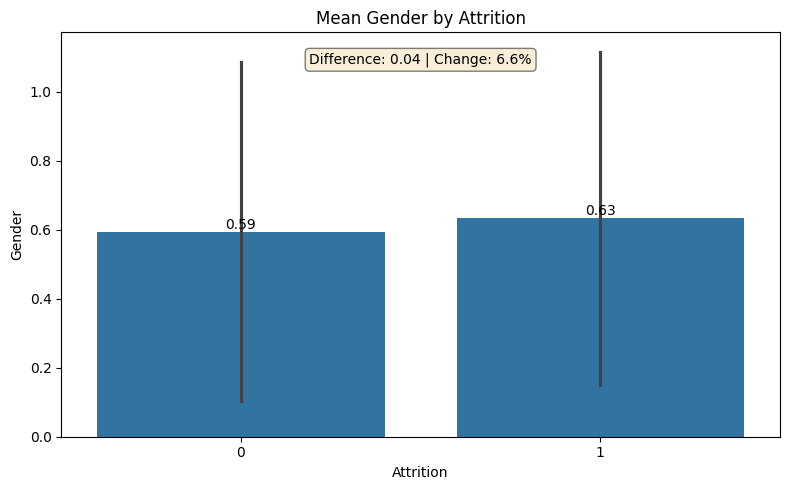

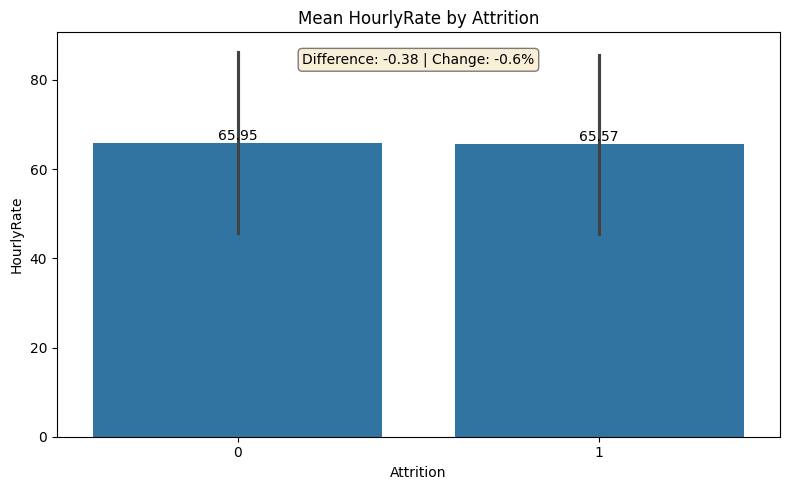

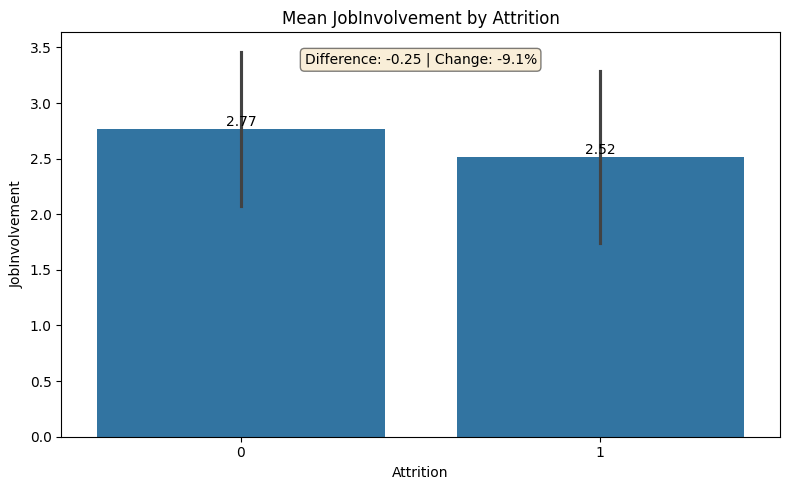

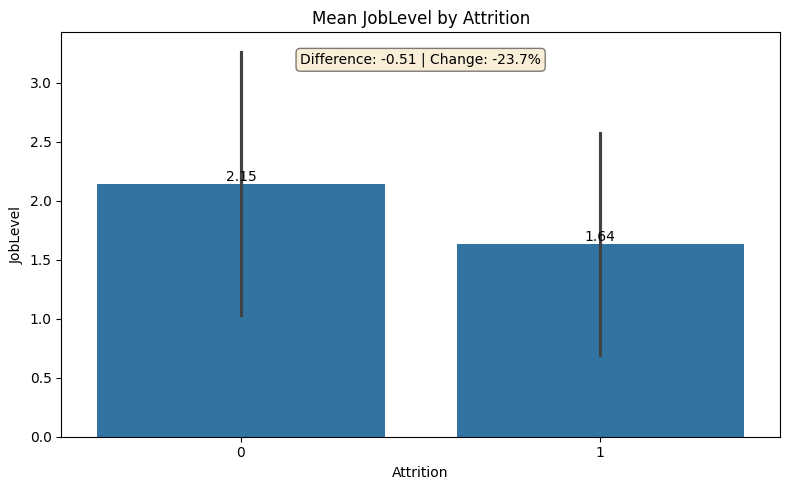

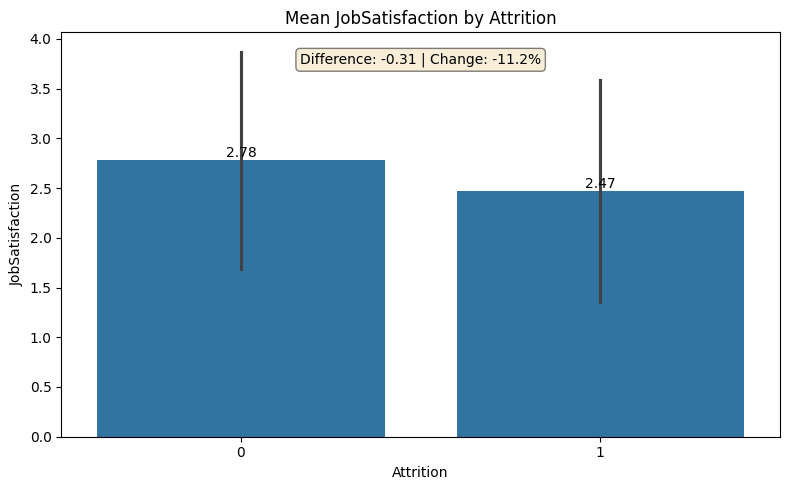

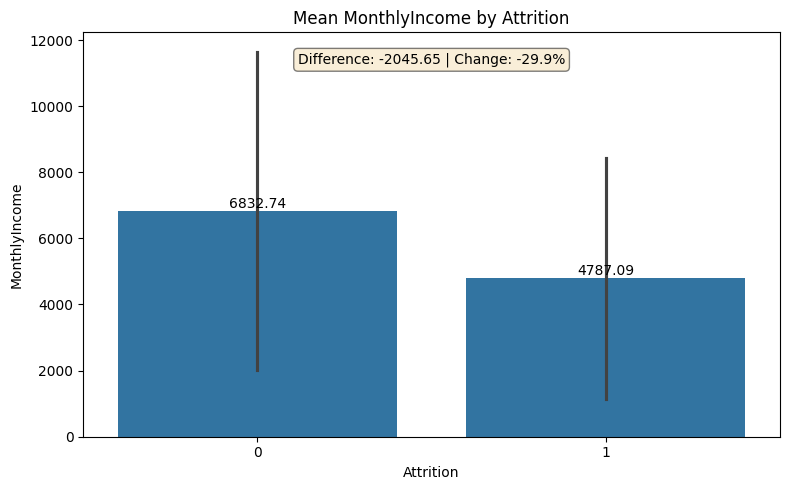

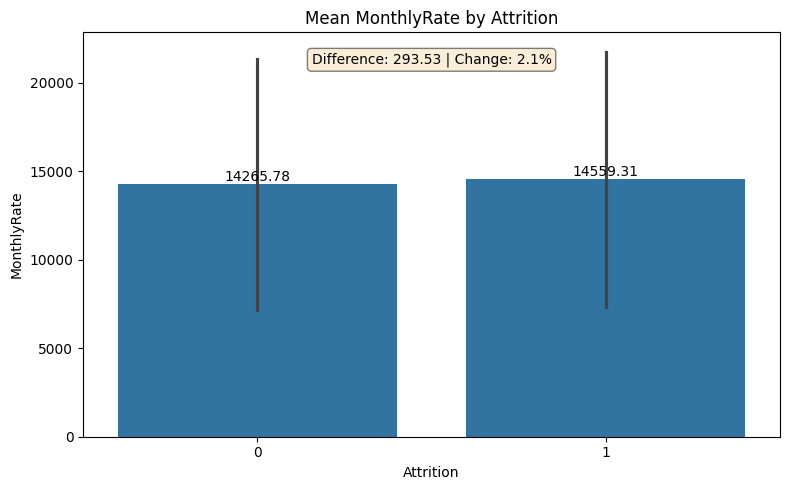

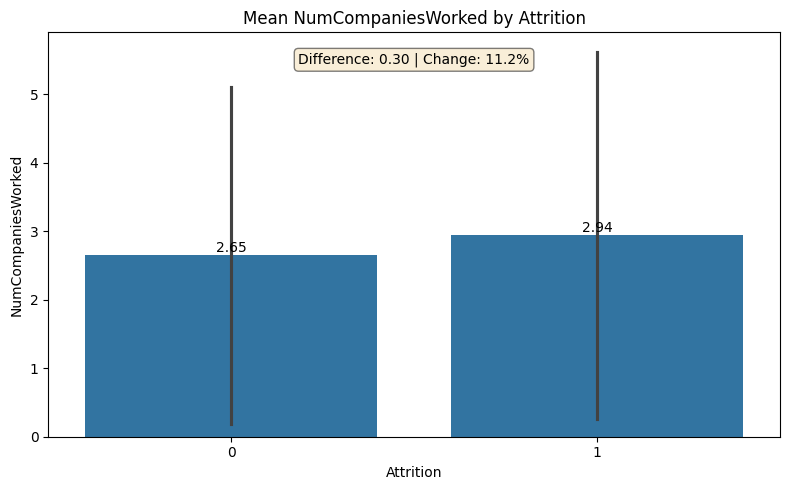

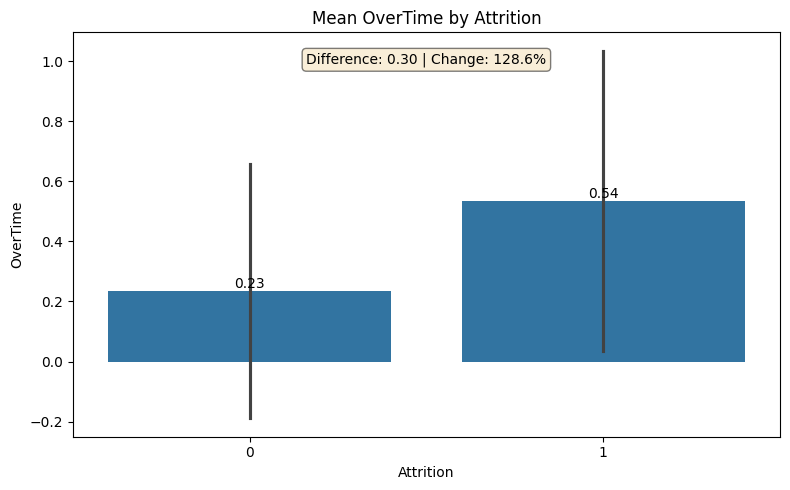

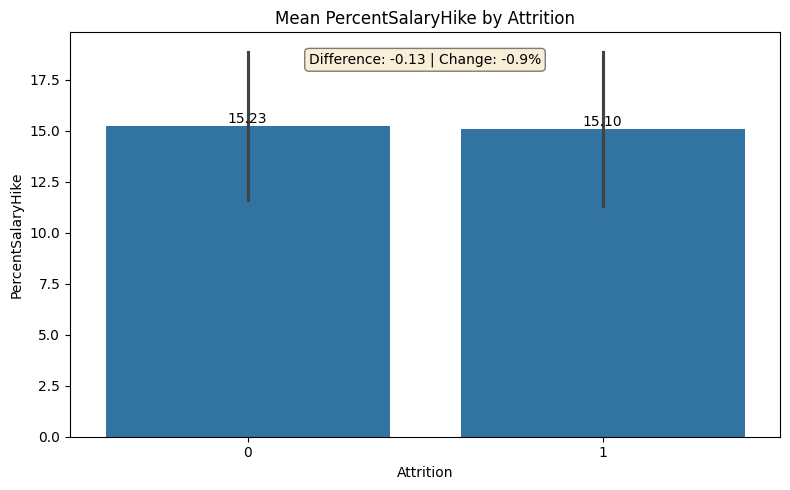

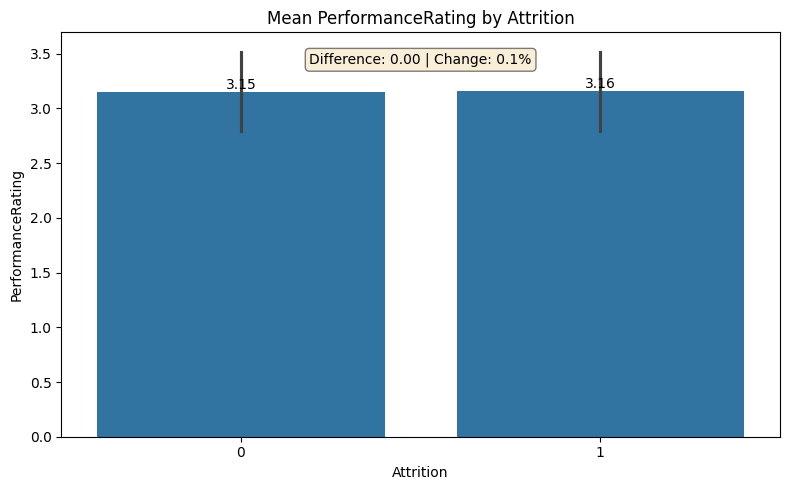

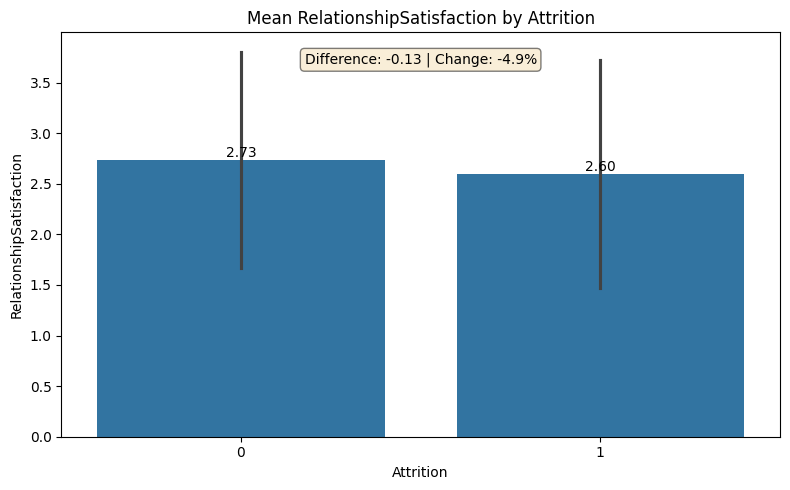

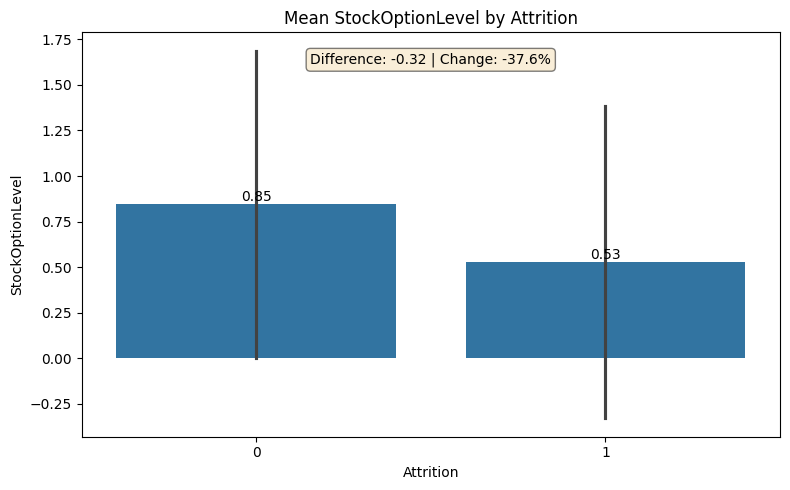

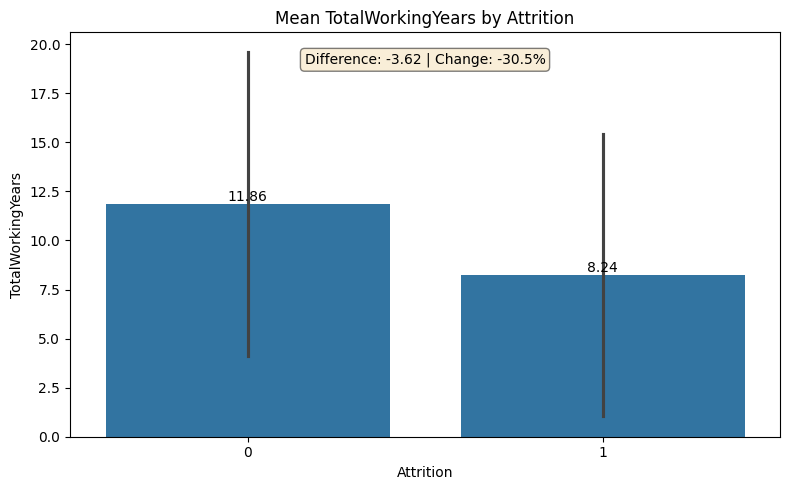

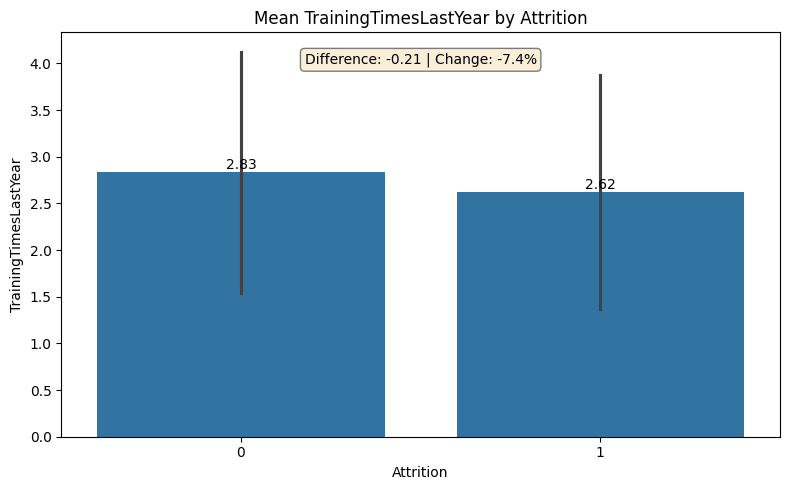

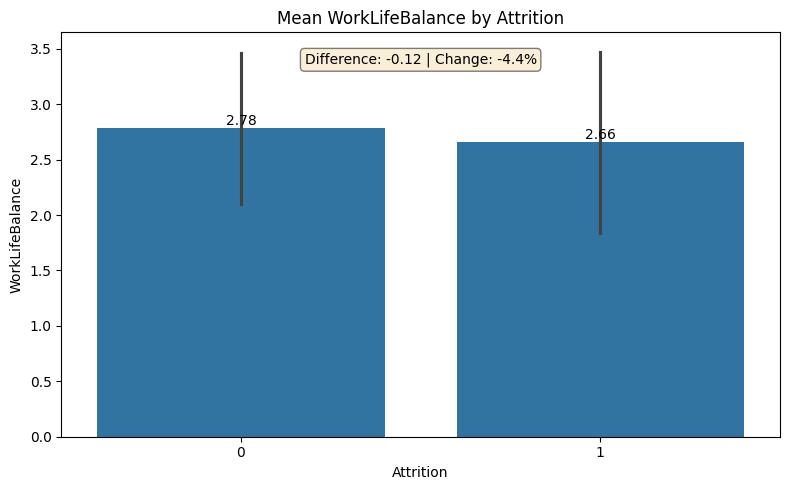

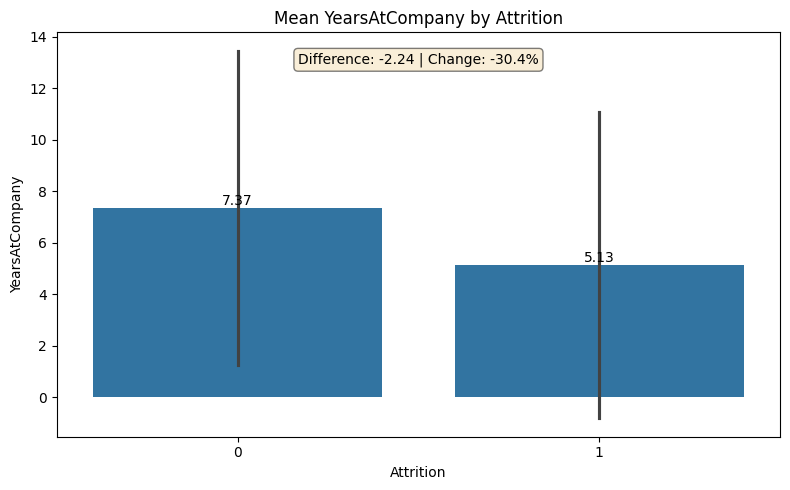

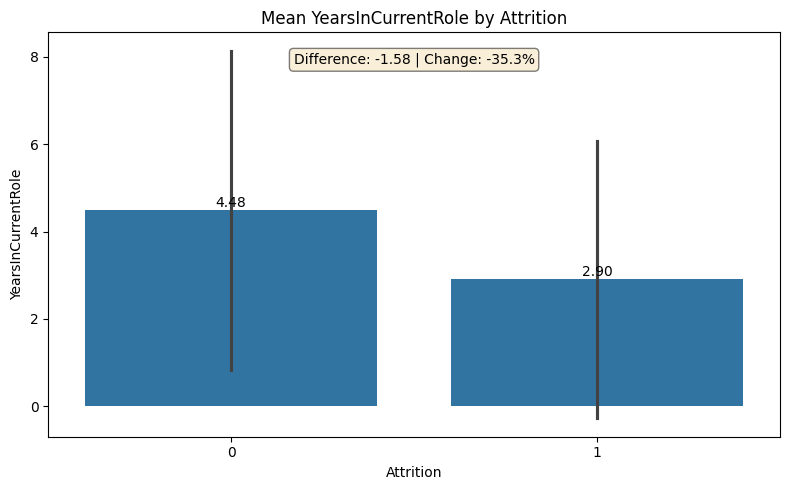

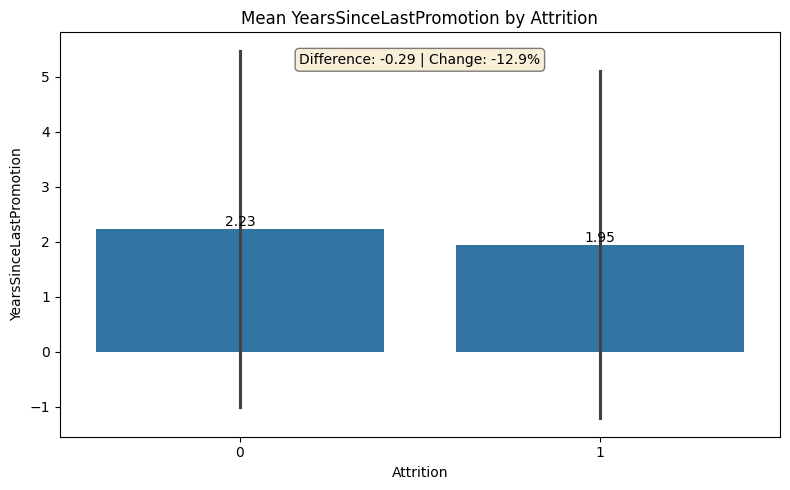

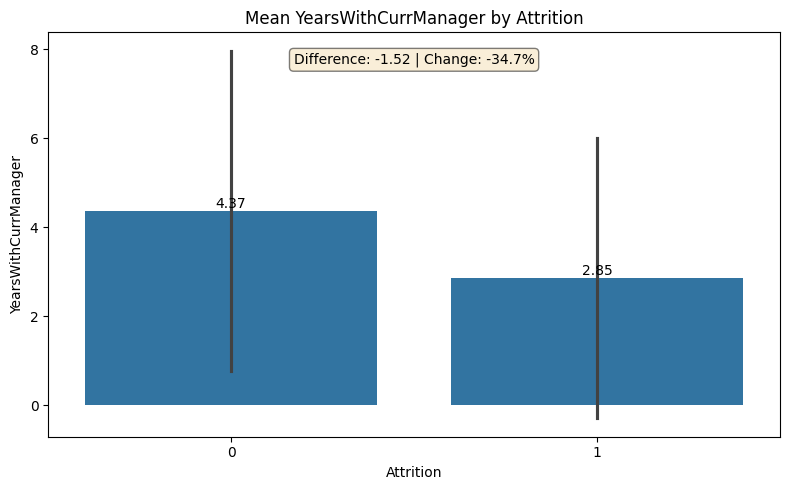

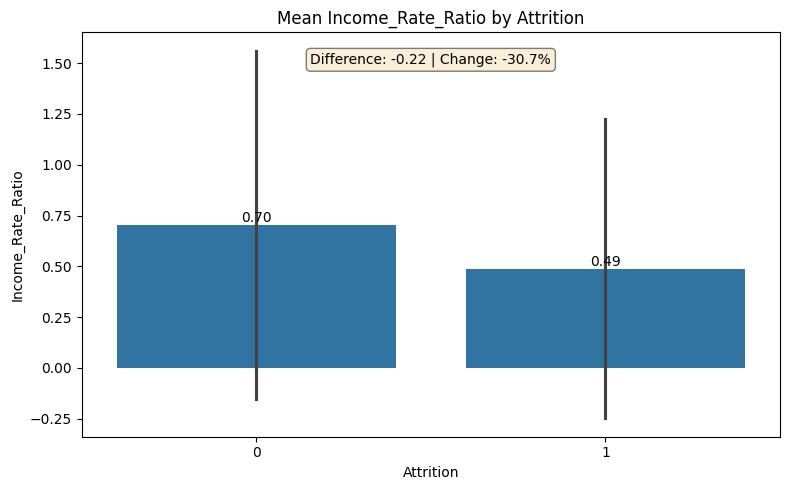


Top 10 variáveis com maior variação percentual:
OverTime                128.623363
StockOptionLevel         37.589592
YearsInCurrentRole       35.262402
YearsWithCurrManager     34.690596
Income_Rate_Ratio        30.739029
TotalWorkingYears        30.500124
YearsAtCompany           30.373338
MonthlyIncome            29.938896
JobLevel                 23.711932
DistanceFromHome         19.261164
dtype: float64


In [ ]:
# Dicionário para guardar as percentagens
percentage_dict = {}

numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

for col in numeric_cols:
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x=data['Attrition'], y=data[col], errorbar='sd')

    # Remover a variável Attrition da lista
    if 'Attrition' in numeric_cols:
        numeric_cols.remove('Attrition')

    # Calcular médias
    means = data.groupby('Attrition')[col].mean()
    
    mean_no = means.get('No', means.iloc[0])
    mean_yes = means.get('Yes', means.iloc[1])
    
    # Calcular diferença e percentagem
    difference = mean_yes - mean_no
    percentage = ((mean_yes / mean_no) - 1) * 100 if mean_no != 0 else 0
    
    # Guardar percentagem
    percentage_dict[col] = percentage
    
    # Adicionar valores das médias
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f')
    
    # Adicionar texto com a relação entre médias
    plt.text(0.5, 0.95, f'Difference: {difference:.2f} | Change: {percentage:.1f}%', 
             transform=ax.transAxes, ha='center', va='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.title(f'Mean {col} by Attrition')
    plt.tight_layout()
    plt.show()

# Mostrar top 10 variáveis com maior percentagem (em valor absoluto)
top_10 = pd.Series(percentage_dict).abs().sort_values(ascending=False).head(10)
print("\nTop 10 variáveis com maior variação percentual:")
print(top_10)

By analyzing the variables with the largest percentage differences between attrition outcomes, several key patterns emerge:

- **OverTime** demonstrates by far the highest percentage variation (128.6%), more than three times greater than any other variable. This suggests that overtime work is the single most critical factor associated with employee attrition and warrants immediate attention in retention strategies.

- **Stock Options** show a substantial 37.6% variation, with employees possessing stock options exhibiting significantly lower attrition rates. This suggests that equity compensation may serve as an effective retention strategy, by strengthening organizational commitment and long-term alignment with the company's success.

- **Tenure-related variables** (Years in Current Role: 35.3%, Years with Current Manager: 34.7%, Years at Company: 30.4%, Total Working Years: 30.5%) consistently rank among the top differentiators. Employees with higher tenure across these dimensions show lower attrition rates, indicating that role stability, manager continuity, and organizational tenure contribute positively to retention.

- The newly created **Income_Rate_Ratio** (30.7%) exhibits greater percentage variation than either MonthlyIncome (29.9%) or MonthlyRate alone. This suggests that the relationship between these compensation metrics may reveal misalignment between employee remuneration and their perceived organizational value, potentially contributing to attrition decisions.

However, these observations are preliminary and reflect observable relationships. Statistical testing and multivariate analysis will be necessary to establish the strength and significance of these relationships while controlling for potential confounding variables and interactions.